# GNN-MAPS: Hybrid Model (Protein + Spatial Features)

**Option 3: Hybrid MLP+GNN Architecture**

This notebook implements a **hybrid model** that combines:
- ✅ **MLP branch**: Learns from protein markers (like MAPS)
- ✅ **GNN branch**: Learns from spatial neighborhood context
- ✅ **Fusion**: Concatenates both representations for classification

## Hypothesis:
Combining protein features AND spatial context should give the best of both worlds!

## Expected Results:
- Better than pure MLP (adds spatial context)
- Better than pure GNN (protein features are strong)
- Should handle spatial split better than pure GNN

## Configuration:
- **Hidden Dimension:** 512 (matches MAPS)
- **MLP Branch:** 4 layers (MAPS architecture)
- **GNN Branch:** 2 GraphSAGE layers
- **Fusion:** Concatenate [MLP features + GNN features]
- **Split:** Spatial 80/20 (same as gnn-maps-3)

---

In [1]:
# Install PyTorch Geometric and its dependencies (Kaggle-compatible)
import sys
import torch

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

!pip install -q torch-geometric

import torch
pytorch_version = torch.__version__.split('+')[0]
cuda_version = torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'

print(f"\nInstalling PyG extensions for PyTorch {pytorch_version} and CUDA {cuda_version}...")

if torch.cuda.is_available():
    !pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{pytorch_version}+cu{cuda_version}.html
else:
    !pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{pytorch_version}+cpu.html

print("\n✅ PyTorch Geometric installation complete!")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:0000:01

Installing PyG extensions for PyTorch 2.8.0 and CUDA 126...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 113.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 114.8 MB/s eta 0:00:0000:01

✅ PyTorch Geometric installation complete!


In [2]:
# Quick verification test
try:
    import torch
    from torch_geometric.nn import SAGEConv
    
    test_conv = SAGEConv(16, 32)
    print("✅ PyTorch Geometric is working correctly!")
    print(f"   Test layer created: {test_conv}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    print("Please re-run the installation cell above.")

✅ PyTorch Geometric is working correctly!
   Test layer created: SAGEConv(16, 32, aggr=mean)


In [3]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

print("✅ All libraries loaded successfully!")
print(f"   - PyTorch version: {torch.__version__}")
print(f"   - CUDA available: {torch.cuda.is_available()}")
print(f"   - Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

/kaggle/input/chl-codex-annotated/cHL_CODEX_annotation.csv
✅ All libraries loaded successfully!
   - PyTorch version: 2.8.0+cu126
   - CUDA available: True
   - Device: GPU


# 1. Load Data

In [4]:
df = pd.read_csv("/kaggle/input/chl-codex-annotated/cHL_CODEX_annotation.csv")
pd.set_option('display.max_columns', None)
display(df.head())
print(f"\nDataset shape: {df.shape}")

,cellLabel,X_cent,Y_cent,cellSize,cellType,BCL.2,CCR6,CD11b,CD11c,CD15,CD16,CD162,CD163,CD2,CD20,CD206,CD25,CD30,CD31,CD4,CD44,CD45RA,CD45RO,CD45,CD5,CD56,CD57,CD68,CD69,CD7,CD8,Collagen.4,Cytokeratin,DAPI.01,EGFR,FoxP3,Granzyme.B,HLA.DR,IDO.1,LAG.3,MCT,MMP.9,MUC.1,PD.1,PD.L1,Podoplanin,T.bet,TCR.g.d,TCRb,Tim.3,VISA,Vimentin,a.SMA,b.Catenin
0,1,75,2,42,B,0.792642,0.617038,0.000089,0.000040,0.000029,0.097688,0.007772,0.005356,0.159593,0.754060,0.000000,0.102301,0.104273,0.000000,0.000000,0.054377,0.761659,0.000000,0.742815,0.131788,0.000479,0.107275,0.000072,0.166675,0.000000,0.000000,0.001391,0.115538,0.808093,0.461070,0.0,0.001300,0.781303,0.000865,0.017596,0.000571,0.273973,0.000000,0.059137,0.091339,0.114237,0.241829,0.681727,0.159092,0.006533,0.000454,0.139826,0.0,0.057827
1,2,1767,2,63,DC,0.000000,0.127394,0.062173,0.660572,0.000000,0.000000,0.172885,0.006180,0.000000,0.000000,0.053359,0.008472,0.000750,0.107943,0.016752,0.020134,0.026217,0.333890,0.050817,0.000000,0.859607,0.000000,0.011369,0.039442,0.000000,0.097343,0.025035,0.091633,0.484774,0.110559,0.0,0.001300,1.000000,0.380801,0.020411,0.000571,0.020548,0.005277,0.010586,0.163511,0.000193,0.010475,0.231264,0.058234,0.111610,0.182849,0.899717,0.0,0.267198
2,3,2545,2,29,NK,0.060620,0.134818,0.298522,0.083348,0.000000,0.182152,0.000210,0.001401,0.000000,0.000000,0.394073,0.070417,0.000000,0.010536,0.000000,0.022717,0.059562,0.233413,0.000000,0.000000,0.456157,0.425833,0.000000,0.699781,0.000000,0.000000,0.001391,0.115538,0.425240,0.350698,0.0,0.024695,0.047437,0.394926,0.167511,0.000571,0.006849,0.406332,0.110243,0.170917,0.000193,0.033671,0.201099,0.000000,0.004900,0.454174,0.069180,0.0,0.104686
3,4,2899,3,64,Monocyte,0.000000,0.012896,0.287698,0.268121,0.000000,0.124361,0.016805,0.208045,0.037673,0.000019,0.226853,0.389436,0.000000,0.000063,0.009068,0.000000,0.064621,0.021957,0.234302,0.020596,0.009104,0.331627,0.137570,0.088045,0.000000,0.000000,0.100139,0.844622,0.352126,0.000000,0.0,0.003899,0.057845,0.002306,0.293497,0.000571,0.157534,1.000000,0.069358,0.052713,0.005982,0.000000,0.000000,0.052230,0.148087,0.228221,0.053541,1.0,0.283151
4,5,3657,3,61,CD4,0.201057,0.110590,0.000000,0.000000,0.000000,0.000000,0.745316,0.013513,0.292691,0.039192,0.000000,0.207973,0.055012,0.032742,0.458688,0.047203,0.069221,0.269690,0.214097,0.095327,0.000479,0.000000,0.086232,0.021121,0.705442,0.019364,0.045897,0.027888,0.603429,0.249414,0.0,0.324929,0.000000,0.000288,0.000000,0.000571,0.191781,0.001319,0.105133,0.026865,0.011771,0.124955,0.154981,0.597647,0.013284,0.000454,0.234038,0.0,0.000000



Dataset shape: (145161, 54)


# 2. Data Preparation & Graph Construction

In [5]:
print("=" * 80)
print("OPTION 3: HYBRID MODEL (PROTEIN + SPATIAL FEATURES)")
print("=" * 80)

# Column definitions
x_col = 'X_cent'
y_col = 'Y_cent'  
label_col = 'cellType'

marker_cols = [
    'BCL.2', 'CCR6', 'CD11b', 'CD11c', 'CD15', 'CD16', 'CD162', 'CD163', 
    'CD2', 'CD20', 'CD206', 'CD25', 'CD30', 'CD31', 'CD4', 'CD44', 
    'CD45RA', 'CD45RO', 'CD45', 'CD5', 'CD56', 'CD57', 'CD68', 'CD69', 
    'CD7', 'CD8', 'Collagen.4', 'Cytokeratin', 'DAPI.01', 'EGFR', 
    'FoxP3', 'Granzyme.B', 'HLA.DR', 'IDO.1', 'LAG.3', 'MCT', 'MMP.9', 
    'MUC.1', 'PD.1', 'PD.L1', 'Podoplanin', 'T.bet', 'TCR.g.d', 'TCRb', 
    'Tim.3', 'VISA', 'Vimentin', 'a.SMA', 'b.Catenin'
]

print(f"\n✅ Using {len(marker_cols)} protein markers")
print(f"✅ Total cells: {len(df):,}")
print(f"✅ Cell types: {df[label_col].nunique()}")

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(df[marker_cols].values)
x = torch.tensor(X_normalized, dtype=torch.float)

# Encode labels
unique_labels = sorted(df[label_col].unique())
label_map = {name: i for i, name in enumerate(unique_labels)}
y = torch.tensor(df[label_col].map(label_map).values, dtype=torch.long)
num_classes = len(label_map)

print(f"\n📊 {num_classes} cell types encoded")

# Build KNN graph
print(f"\n🔗 Building KNN Graph (K=5)...")
k_neighbors = 5
coords = df[[x_col, y_col]].values

nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)

source_nodes = np.repeat(np.arange(len(df)), k_neighbors)
target_nodes = indices[:, 1:].flatten()
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

print(f"✅ Graph: {edge_index.shape[1]:,} edges")

# Spatial split (80/20 by X-axis)
print(f"\n" + "=" * 80)
print("SPATIAL TRAIN/TEST SPLIT (80/20 by X-axis)")
print("=" * 80)

x_min = df[x_col].min()
x_max = df[x_col].max()
x_threshold = x_min + (0.8 * (x_max - x_min))

train_mask = torch.tensor(df[x_col].values <= x_threshold, dtype=torch.bool)
test_mask = torch.tensor(df[x_col].values > x_threshold, dtype=torch.bool)

print(f"\n✅ SPATIAL SPLIT")
print(f"   Train: {train_mask.sum():,} cells ({100*train_mask.float().mean():.1f}%)")
print(f"   Test:  {test_mask.sum():,} cells ({100*test_mask.float().mean():.1f}%)")
print(f"   This is the SAME split as gnn-maps-3 (for fair comparison)")

# Create PyG Data object
data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
    train_mask=train_mask,
    test_mask=test_mask
)

print(f"\n{data}")

OPTION 3: HYBRID MODEL (PROTEIN + SPATIAL FEATURES)

✅ Using 49 protein markers
✅ Total cells: 145,161
✅ Cell types: 18

📊 18 cell types encoded

🔗 Building KNN Graph (K=5)...
✅ Graph: 725,805 edges

SPATIAL TRAIN/TEST SPLIT (80/20 by X-axis)

✅ SPATIAL SPLIT
   Train: 117,953 cells (81.3%)
   Test:  27,208 cells (18.7%)
   This is the SAME split as gnn-maps-3 (for fair comparison)

Data(x=[145161, 49], edge_index=[2, 725805], y=[145161], train_mask=[145161], test_mask=[145161])


/tmp/ipykernel_55/3474786668.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)


# 3. Hybrid Model Architecture

In [6]:
print("=" * 80)
print("HYBRID MODEL: MLP + GNN FUSION")
print("=" * 80)

class HybridGNN(torch.nn.Module):
    """
    Hybrid Model: Combines MLP (protein features) + GNN (spatial context)
    
    Architecture:
    1. MLP Branch: 4-layer network (MAPS-style) processes protein markers
    2. GNN Branch: 2-layer GraphSAGE aggregates spatial neighborhood info
    3. Fusion: Concatenate [MLP features + GNN features] → classifier
    
    This gives the best of both worlds:
    - Strong protein marker features (like MAPS)
    - Rich spatial context (like pure GNN)
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        
        # MLP Branch (processes protein markers independently)
        self.mlp_fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.mlp_fc2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.mlp_fc3 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.mlp_fc4 = torch.nn.Linear(hidden_channels, hidden_channels)
        
        # GNN Branch (aggregates spatial neighborhood)
        self.gnn_conv1 = SAGEConv(in_channels, hidden_channels)
        self.gnn_conv2 = SAGEConv(hidden_channels, hidden_channels)
        
        # Fusion layer (combines both representations)
        self.classifier = torch.nn.Linear(hidden_channels * 2, out_channels)
        
        self.dropout = dropout
    
    def forward(self, x, edge_index):
        # MLP Branch: Process protein markers
        mlp_out = F.relu(self.mlp_fc1(x))
        mlp_out = F.dropout(mlp_out, p=self.dropout, training=self.training)
        mlp_out = F.relu(self.mlp_fc2(mlp_out))
        mlp_out = F.dropout(mlp_out, p=self.dropout, training=self.training)
        mlp_out = F.relu(self.mlp_fc3(mlp_out))
        mlp_out = F.dropout(mlp_out, p=self.dropout, training=self.training)
        mlp_out = F.relu(self.mlp_fc4(mlp_out))
        mlp_out = F.dropout(mlp_out, p=self.dropout, training=self.training)
        
        # GNN Branch: Aggregate spatial context
        gnn_out = self.gnn_conv1(x, edge_index)
        gnn_out = F.relu(gnn_out)
        gnn_out = F.dropout(gnn_out, p=self.dropout, training=self.training)
        gnn_out = self.gnn_conv2(gnn_out, edge_index)
        gnn_out = F.relu(gnn_out)
        gnn_out = F.dropout(gnn_out, p=self.dropout, training=self.training)
        
        # Fusion: Concatenate both representations
        combined = torch.cat([mlp_out, gnn_out], dim=1)
        
        # Final classification
        out = self.classifier(combined)
        return F.log_softmax(out, dim=1)

# Also keep baseline models for comparison
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc3 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc4 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.classifier = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index=None):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.fc4(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.1):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

print("\n✅ Models defined:")
print("   1. MLP (baseline - protein only)")
print("   2. GraphSAGE (baseline - spatial only)")
print("   3. HybridGNN (protein + spatial)")
print("\n🔬 Hybrid Architecture:")
print("   Input (49 markers) →")
print("   ├─ MLP: 49 → 512 → 512 → 512 → 512")
print("   └─ GNN: 49 → 512 → 512")
print("   Concat: [512 MLP + 512 GNN] = 1024")
print("   Classifier: 1024 → num_classes")

HYBRID MODEL: MLP + GNN FUSION

✅ Models defined:
   1. MLP (baseline - protein only)
   2. GraphSAGE (baseline - spatial only)
   3. HybridGNN (protein + spatial)

🔬 Hybrid Architecture:
   Input (49 markers) →
   ├─ MLP: 49 → 512 → 512 → 512 → 512
   └─ GNN: 49 → 512 → 512
   Concat: [512 MLP + 512 GNN] = 1024
   Classifier: 1024 → num_classes


# 4. Training (All Three Models)

💻 Device: cuda
   GPU: Tesla P100-PCIE-16GB

⚙️  Hyperparameters: hidden=512, epochs=500

TRAINING ALL MODELS FOR COMPARISON

TRAINING MLP (Baseline)

Epoch | Loss    | Train Acc | Train F1 | Test Acc | Test F1 | Status
--------------------------------------------------------------------------------
    1 |  2.8943 |    0.2631 |   0.1187 |   0.2753 |  0.1255 | ✅ BEST
   10 |  1.8418 |    0.5385 |   0.4673 |   0.5287 |  0.4432 | ✅ BEST
   20 |  1.0569 |    0.6998 |   0.6727 |   0.6797 |  0.6439 | ✅ BEST
   30 |  0.7868 |    0.7642 |   0.7552 |   0.7482 |  0.7374 | ✅ BEST
   40 |  0.6751 |    0.7893 |   0.7830 |   0.7712 |  0.7630 | ✅ BEST
   50 |  0.6101 |    0.8059 |   0.7997 |   0.7861 |  0.7775 | ✅ BEST
   60 |  0.5637 |    0.8172 |   0.8118 |   0.7984 |  0.7909 | ✅ BEST
   70 |  0.5300 |    0.8272 |   0.8225 |   0.8060 |  0.7993 | ✅ BEST
   80 |  0.5006 |    0.8358 |   0.8313 |   0.8137 |  0.8073 | ✅ BEST
   90 |  0.4765 |    0.8435 |   0.8393 |   0.8207 |  0.8149 | ✅ BEST
  100 |  

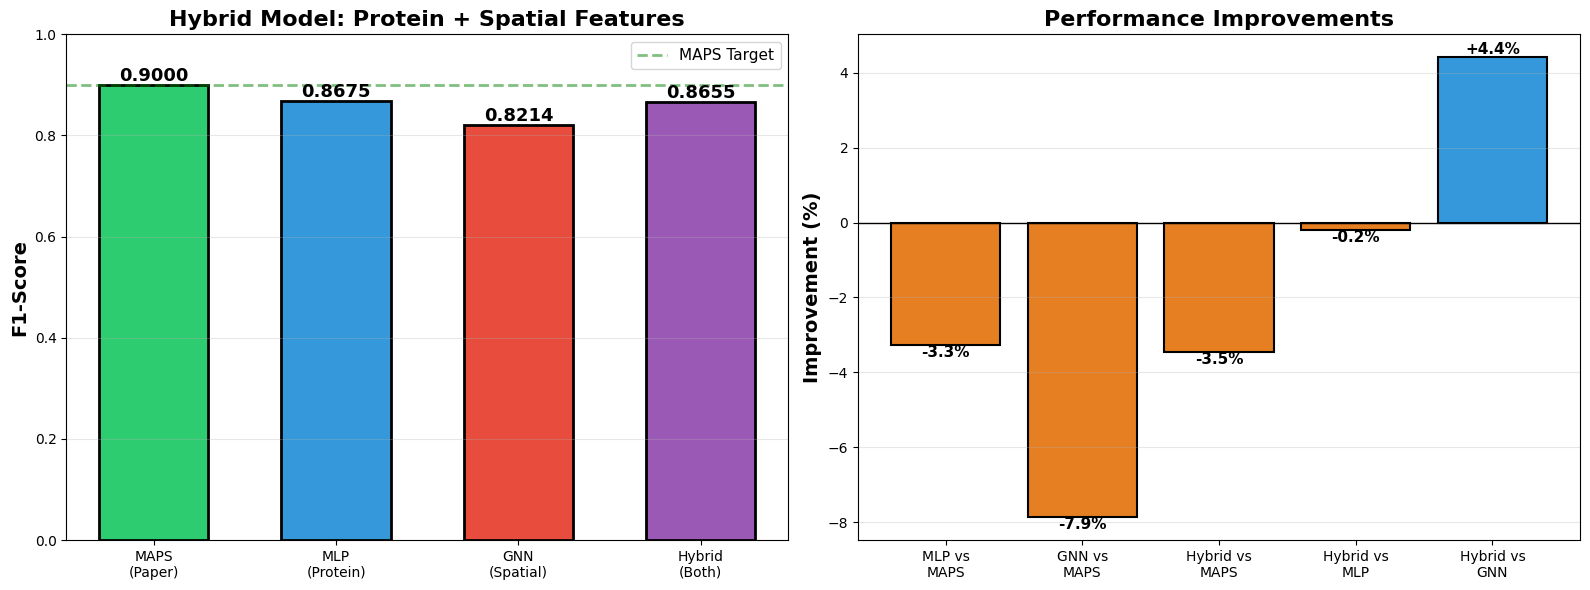


🚀 ANALYSIS COMPLETE!

💻 Hardware: Tesla P100-PCIE-16GB
⚙️  Config: Spatial Split, Hybrid Architecture, hidden=512
📊 Final Results:
   MLP:      86.7%
   GNN:      82.1%
   Hybrid:   86.5%
   MAPS:     90.0%


In [7]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# Hyperparameters
hidden_dim = 512
dropout = 0.1
lr = 0.001
max_epochs = 500
min_epochs = 250
patience = 100

print(f"\n⚙️  Hyperparameters: hidden={hidden_dim}, epochs={max_epochs}")

# Training functions
def train_epoch_with_loss(model, data, optimizer):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate(model, data, mask):
    model.eval()
    data_device = data.to(device)
    out = model(data_device.x, data_device.edge_index)
    pred = out.argmax(dim=1)
    
    y_true = data_device.y[mask].cpu().numpy()
    y_pred = pred[mask].cpu().numpy()
    
    acc = (pred[mask] == data_device.y[mask]).sum().item() / mask.sum().item()
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    return acc, f1

# Function to train any model
def train_model(model, model_name, data, lr, max_epochs, min_epochs, patience):
    print("\n" + "=" * 80)
    print(f"TRAINING {model_name}")
    print("=" * 80)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    print(f"\nEpoch | Loss    | Train Acc | Train F1 | Test Acc | Test F1 | Status")
    print("-" * 80)
    
    best_f1 = 0
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(1, max_epochs + 1):
        loss = train_epoch_with_loss(model, data, optimizer)
        
        if epoch % 10 == 0 or epoch == 1:
            train_acc, train_f1 = evaluate(model, data, data.train_mask)
            test_acc, test_f1 = evaluate(model, data, data.test_mask)
            
            status = ""
            if test_f1 > best_f1:
                best_f1 = test_f1
                best_epoch = epoch
                patience_counter = 0
                status = "✅ BEST"
            else:
                patience_counter += 10
                if epoch >= min_epochs and patience_counter >= patience:
                    status = "🛑 EARLY STOP"
                
            print(f'{epoch:5d} | {loss:7.4f} | {train_acc:9.4f} | {train_f1:8.4f} | '
                  f'{test_acc:8.4f} | {test_f1:7.4f} | {status}')
            
            if epoch >= min_epochs and patience_counter >= patience:
                print(f"\n⏸️  Early stopping!")
                break
    
    print(f"\n✅ {model_name} Complete! Best F1: {best_f1:.4f} (epoch {best_epoch})")
    return best_f1, best_epoch

# Train all three models
print("\n" + "=" * 80)
print("TRAINING ALL MODELS FOR COMPARISON")
print("=" * 80)

# 1. MLP Baseline
mlp_model = MLP(len(marker_cols), hidden_dim, num_classes, dropout).to(device)
mlp_f1, mlp_epoch = train_model(mlp_model, "MLP (Baseline)", data, lr, max_epochs, min_epochs, patience)

# 2. GraphSAGE Baseline
gnn_model = GraphSAGE(len(marker_cols), hidden_dim, num_classes, dropout).to(device)
gnn_f1, gnn_epoch = train_model(gnn_model, "GraphSAGE (Baseline)", data, lr, max_epochs, min_epochs, patience)

# 3. Hybrid Model (STAR OF THE SHOW!)
hybrid_model = HybridGNN(len(marker_cols), hidden_dim, num_classes, dropout).to(device)
hybrid_f1, hybrid_epoch = train_model(hybrid_model, "HybridGNN (Protein+Spatial)", data, lr, max_epochs, min_epochs, patience)

# ==========================================
# FINAL COMPARISON
# ==========================================
print("\n" + "=" * 80)
print("FINAL RESULTS: THREE-WAY COMPARISON")
print("=" * 80)

# Get final test scores
mlp_test_acc, mlp_test_f1 = evaluate(mlp_model, data, data.test_mask)
gnn_test_acc, gnn_test_f1 = evaluate(gnn_model, data, data.test_mask)
hybrid_test_acc, hybrid_test_f1 = evaluate(hybrid_model, data, data.test_mask)

print(f"\n{'Model':<30s} {'Accuracy':>12s} {'F1-Score':>12s} {'vs MAPS':>12s}")
print("-" * 75)
print(f"{'MAPS (Paper Baseline)':<30s} {'N/A':>12s} {'0.9000':>12s} {'1.00x':>12s}")
print(f"{'MLP (Protein Only)':<30s} {mlp_test_acc:>12.4f} {mlp_test_f1:>12.4f} {mlp_test_f1/0.90:>11.2f}x")
print(f"{'GraphSAGE (Spatial Only)':<30s} {gnn_test_acc:>12.4f} {gnn_test_f1:>12.4f} {gnn_test_f1/0.90:>11.2f}x")
print(f"{'HybridGNN (Protein+Spatial)':<30s} {hybrid_test_acc:>12.4f} {hybrid_test_f1:>12.4f} {hybrid_test_f1/0.90:>11.2f}x")
print("-" * 75)

# Analysis
print(f"\n📊 Performance Analysis:")
print(f"   Hybrid vs MLP:  {(hybrid_test_f1 - mlp_test_f1)*100:+.2f} pp ({((hybrid_test_f1 - mlp_test_f1)/mlp_test_f1)*100:+.1f}%)")
print(f"   Hybrid vs GNN:  {(hybrid_test_f1 - gnn_test_f1)*100:+.2f} pp ({((hybrid_test_f1 - gnn_test_f1)/gnn_test_f1)*100:+.1f}%)")
print(f"   Hybrid vs MAPS: {(hybrid_test_f1 - 0.90)*100:+.2f} pp ({((hybrid_test_f1 - 0.90)/0.90)*100:+.1f}%)")

# Determine winner
best_model = max([(mlp_test_f1, 'MLP'), (gnn_test_f1, 'GraphSAGE'), (hybrid_test_f1, 'Hybrid')], key=lambda x: x[0])
print(f"\n🏆 Best Model: {best_model[1]} with {best_model[0]:.1%} F1")

if hybrid_test_f1 > max(mlp_test_f1, gnn_test_f1):
    print(f"\n✅ HYBRID MODEL WINS!")
    print(f"   Combining protein + spatial features beats both baselines!")
    if hybrid_test_f1 > 0.90:
        print(f"   🎉 AND IT BEATS MAPS (90%)!")
elif mlp_test_f1 > gnn_test_f1:
    print(f"\n📊 MLP wins (protein features stronger than spatial for this split)")
else:
    print(f"\n📊 GNN wins (spatial context helps despite distribution shift)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
ax = axes[0]
models = ['MAPS\n(Paper)', 'MLP\n(Protein)', 'GNN\n(Spatial)', 'Hybrid\n(Both)']
f1_scores = [0.90, mlp_test_f1, gnn_test_f1, hybrid_test_f1]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

bars = ax.bar(models, f1_scores, color=colors, edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
ax.set_title('Hybrid Model: Protein + Spatial Features', fontsize=16, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.axhline(y=0.90, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MAPS Target')
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=11)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=13, fontweight='bold')

# Improvement breakdown
ax2 = axes[1]
comparisons = ['MLP vs\nMAPS', 'GNN vs\nMAPS', 'Hybrid vs\nMAPS', 'Hybrid vs\nMLP', 'Hybrid vs\nGNN']
improvements = [
    (mlp_test_f1 - 0.90) * 100,
    (gnn_test_f1 - 0.90) * 100,
    (hybrid_test_f1 - 0.90) * 100,
    (hybrid_test_f1 - mlp_test_f1) * 100,
    (hybrid_test_f1 - gnn_test_f1) * 100
]
colors2 = ['#3498db' if v >= 0 else '#e67e22' for v in improvements]

bars2 = ax2.bar(comparisons, improvements, color=colors2, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Improvement (%)', fontsize=14, fontweight='bold')
ax2.set_title('Performance Improvements', fontsize=16, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:+.1f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("🚀 ANALYSIS COMPLETE!")
print("=" * 80)
print(f"\n💻 Hardware: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"⚙️  Config: Spatial Split, Hybrid Architecture, hidden=512")
print(f"📊 Final Results:")
print(f"   MLP:      {mlp_test_f1:.1%}")
print(f"   GNN:      {gnn_test_f1:.1%}")
print(f"   Hybrid:   {hybrid_test_f1:.1%}")
print(f"   MAPS:     90.0%")